In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from matplotlib import pyplot as plt
exp_name = "norm_compress"
outdir = Path("/data/lux70/plaid/artifacts/interpolation/") / exp_name
compression_model_id = "jzlv54wl"

if "compress" in exp_name:
    outdir = outdir / compression_model_id

In [2]:
if not outdir.exists():
    outdir.mkdir(parents=True)

import matplotlib
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
matplotlib.rcParams.update({'font.size': 18,
    'axes.labelsize': 20,'axes.titlesize': 20, 'figure.titlesize' : 20})
matplotlib.rcParams['text.usetex'] = False
import matplotlib.gridspec as gridspec
from matplotlib.patheffects import withStroke
from collections import defaultdict
# from mpl_toolkits import mplot3d
# from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

In [3]:
outdir  = outdir / "1jzdC00_to_4ivvA00"
print(outdir)

/data/lux70/plaid/artifacts/interpolation/norm_compress/jzlv54wl/1jzdC00_to_4ivvA00


# Original Protein

In [4]:
import warnings
warnings.filterwarnings('ignore')

cath_ids = ["1jzdC00", "4ivvA00"]
pdb_path1 = f"/data/lux70/data/cath/dompdb/{cath_ids[0]}"
pdb_path2 = f"/data/lux70/data/cath/dompdb/{cath_ids[1]}"

pdb_strs = []
sequences = []

max_len = 100

for pdb_path in [pdb_path1, pdb_path2]:
    from plaid.utils import parse_sequence_from_structure
    
    with open(pdb_path) as f:
        pdb_str = f.read()
    pdb_strs.append(pdb_strs)

    sequence = parse_sequence_from_structure(pdb_str, "")
    print(len(sequence))
    print(sequence)
    sequences.append(sequence)
    
    from plaid.utils import view_py3Dmol
    view_py3Dmol(pdb_str)

118
RSQFVPADQAFAFDFQQNQHDLNLTWQIKDGYYLYRKQIRITPEHAKIADVQLPQGVWHEDEFYGKSEIYRDRLTLPVTINQASAGATLTVTYQGAADAGFCYPPETKTVPLSEVVAN


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

174
ASMEINVSKLRTDLPQVGVQPYRQVHAHSTGNPHSTVQNEADYHWRKDPELGFFSHIVGNGAIMQVGPVDNGAWDVGGGWNAETYAAVELIESHSTKEEFMTDYRLYIELLRNLADEAGLPKTLDTGSLAGIKTHEYATNNQPNNHSDHVDPYPYLAKWGISREQFKHDIENGL


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Crop original protein:

In [5]:
import random
random.seed(42)

from plaid.transforms import get_random_sequence_crop
seq1 = get_random_sequence_crop(sequences[0], 100)
seq2 = get_random_sequence_crop(sequences[1], 100)
print(seq1)
print(seq2)

FVPADQAFAFDFQQNQHDLNLTWQIKDGYYLYRKQIRITPEHAKIADVQLPQGVWHEDEFYGKSEIYRDRLTLPVTINQASAGATLTVTYQGAADAGFCY
EINVSKLRTDLPQVGVQPYRQVHAHSTGNPHSTVQNEADYHWRKDPELGFFSHIVGNGAIMQVGPVDNGAWDVGGGWNAETYAAVELIESHSTKEEFMTD


In [6]:
from plaid.esmfold import esmfold_v1
import torch

device = torch.device("cuda:0")
esmfold = esmfold_v1()
_ = esmfold.to(device)

Creating ESMFold...
ESMFold model loaded in 38.83 seconds.


# Load Hourglass and Auxiliary Models

In [7]:
from plaid.compression import HourglassInference


hourglass_model = HourglassInference(
    compression_model_id=compression_model_id,
    init_compress_mode=True
)
hourglass_model.to(device)

from cheap.proteins import LatentToSequence, LatentToStructure

latent_to_sequence = LatentToSequence()
latent_to_sequence.to(device)

latent_to_structure = LatentToStructure(esmfold=esmfold, delete_esm_lm=False)
latent_to_structure.to(device)


from plaid.utils import LatentScaler
scaler = LatentScaler()

Init hourglass model on rank 0
using quantizer tanh


# Transform and Create Interpolations

## Infer embedding and Transform

In [8]:
emb1 = esmfold.infer_embedding(seq1)['s']
emb2 = esmfold.infer_embedding(seq2)['s']

emb1, emb2 = emb1.to(device), emb2.to(device)
print(emb1.min(), emb2.max())

tensor(-854.0978, device='cuda:0') tensor(2686.6880, device='cuda:0')


In [9]:
if "norm" in exp_name:
    from plaid.utils import LatentScaler
    scaler = LatentScaler()
    emb1 = scaler.scale(emb1)
    emb2 = scaler.scale(emb2)
    print(emb1.min(), emb2.max())

tensor(-1.0119, device='cuda:0') tensor(0.9939, device='cuda:0')


In [10]:
if "compress" in exp_name:
    emb1, _ = hourglass_model.compress(emb1)
    emb2, _ = hourglass_model.compress(emb2)
    print(emb1.min(), emb2.max())

tensor(-0.9974, device='cuda:0') tensor(1., device='cuda:0')


## Interpolate

In [11]:
def interpolate(tensor1, tensor2, t):
    return tensor1 * t + (1 - t) * tensor2

In [12]:
import numpy as np
ts = np.linspace(0, 1, 100)

In [13]:
from tqdm.notebook import tqdm
interpolated_embs = []

for t in tqdm(ts):
    tmp = interpolate(emb1, emb2, t)
    interpolated_embs.append(tmp)

interpolated_embs = torch.concatenate(interpolated_embs, dim=0)
print(interpolated_embs.shape)

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 100, 8])


## Undo Transform

In [14]:
if "compress" in exp_name:
    interpolated_embs = hourglass_model.uncompress(interpolated_embs)
    print(interpolated_embs.shape)
    print(interpolated_embs.max(), interpolated_embs.min())

torch.Size([100, 100, 1024])
tensor(0.9093, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-0.9354, device='cuda:0', grad_fn=<MinBackward1>)


In [15]:
if "norm" in exp_name:
    interpolated_embs = scaler.unscale(interpolated_embs)
    print(interpolated_embs.shape)
    print(interpolated_embs.max(), interpolated_embs.min())

torch.Size([100, 100, 1024])
tensor(2833.6260, device='cuda:0') tensor(-874.1034, device='cuda:0')


# Map Interpolations to Sequence Space

In [16]:
interpolated_sequences = latent_to_sequence.to_sequence(interpolated_embs)[-1]

In [17]:
interpolated_sequences[::10]

['EINVSKLRTDLPQVGVQPYRQVHAHSTGNPHSTVQNEADYHWRKDPELGFFSHIVGNGAIMQVGPVDNGAWDVGGGWNAETYAAVELIESHSTKEEFMTD',
 'EIRVSKLRTDLPQVGVQPYRQVHAHSTGNPHSTVQNEADYHWRKDPELGFFSHIVGNGAIMNVGPVDNGAWDVGGGWNAETWAAVELIESHSTKEEFMTD',
 'YIRVSKIHTELPQVNVQPWRHVHAHSSGQPFTSAQNEAEWHWGKEPEIGFFSRIVGQAALMNVGPVDNGAFEVGSGFNAQTWAAVEIIQTHSTKDQFMTD',
 'YIKARKIHTEFPQVRVQKFRHAWAMSSGQVFTSAQHQAEFHWSKEPEIGFLSRIIGQNCLMNAGCVDKGCFQVSSGFNCHSFCAVEIINTHGTRDQHITD',
 'YIKANKIHCEWPQIKKQKFKFAWCMSRGQILKSAQMQVNLQWSKYADISLLSSIISQQMLFRAGMVDKRTFNVSTSLNKHSLTAAYIINKHGTRDHHLTE',
 'WITANNVFCYYIQMKKQHFKFAWKIRKGQLLHSCQMNVNIQWTKFADIRLIRGILRQDHLFRCGHIERKTLRITASLNKMSITAAWVIKHHGCTDKKLCE',
 'WVTAQNVFAYYLQMNKQQLKLAWKIRKGYFLHSKQINVKIQWTKLADINLPKGVLREDHLWGKSHIERKTLKICASLNKVSISAAFVIKHHGCTDKSLCE',
 'FVTAENVFAWELQHNNHELKLCWHIRKGYFLWRKQIKVKVQHCKLADVNLPNGVLKEDQLWGRSQIYRQSLTIAASLNNASVSAAFCVTWQGCCDCGLCY',
 'FVPADQAFAFEFQHNNHELNLCWNIKEGYWLWRKQIRVTPEHAKIADVNLPNGVFKEDQLYGRSEIYRESLTIPVSINNASVSACLCVTYQGCADAGLCY',
 'FVPADQAFAFDFQQNQHDLNLTWQIKDGYWLYRKQIRITPEHAKIADVQLPNG

(0.0, 1.1)

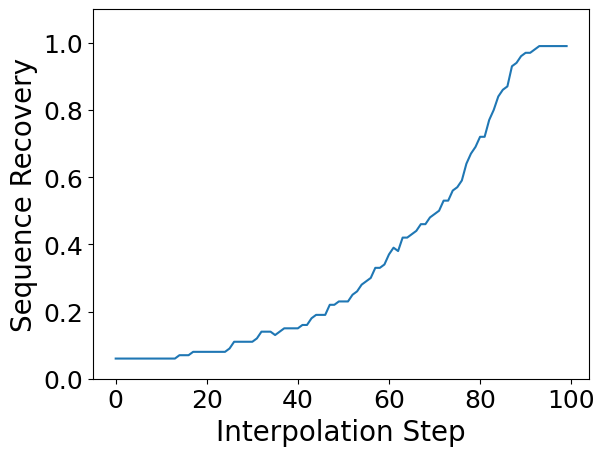

In [18]:
from plaid.utils import calc_sequence_recovery
seq_recovs = [calc_sequence_recovery(seq1, s_tmp) for s_tmp in interpolated_sequences]
plt.plot(np.arange(len(seq_recovs)), seq_recovs)
plt.xlabel("Interpolation Step")
plt.ylabel("Sequence Recovery")
plt.ylim(0,1.1)

In [20]:
if not outdir.exists():
    outdir.mkdir()

In [21]:
with open(outdir / "interpolated_sequences.fasta", "w") as f:
    for seq in interpolated_sequences:
        f.write(f"{seq}\n")

# Map Interpolations to Structure Space

In [22]:
res = latent_to_structure.to_structure(interpolated_embs, interpolated_sequences, batch_size=64)

(Generating structure): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:04<00:00, 32.22s/it]


In [23]:
# noised structures
tm_scores = []
import pickle as pkl

from plaid.evaluation import run_tmalign

if not (outdir / "structures").exists():
    (outdir / "structures").mkdir(parents=True)

for i, pdbstr in enumerate(tqdm(res)):
    fname = outdir / f"structures/interpolation_{i}.pdb"
    with open(fname, "w") as f:
        f.write(pdbstr)
    tm_scores.append(run_tmalign(pdb_path1, fname))
    
pkl.dump(tm_scores, open(outdir / "tmscores.pkl", "wb"))

  0%|          | 0/100 [00:00<?, ?it/s]

(0.0, 1.1)

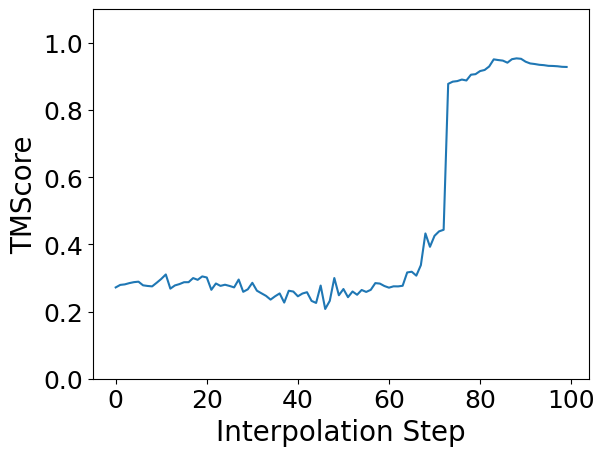

In [24]:
plt.plot(np.arange(len(tm_scores)), tm_scores)
plt.ylabel("TMScore")
plt.xlabel("Interpolation Step")
plt.ylim(0,1.1)

# Plot Embedding Interpolation

In [25]:
print(outdir)   
torch.save(interpolated_embs.cpu(), outdir / "emb.pt") 

/data/lux70/plaid/artifacts/interpolation/norm_compress/jzlv54wl/1jzdC00_to_4ivvA00


In [26]:
import seaborn as sns

interpolated_features = interpolated_embs.mean(dim=1)
print(interpolated_features.shape)

torch.Size([100, 1024])


Text(0.5, 1.0, 'Max value: 2577.12; Min value: -778.10')

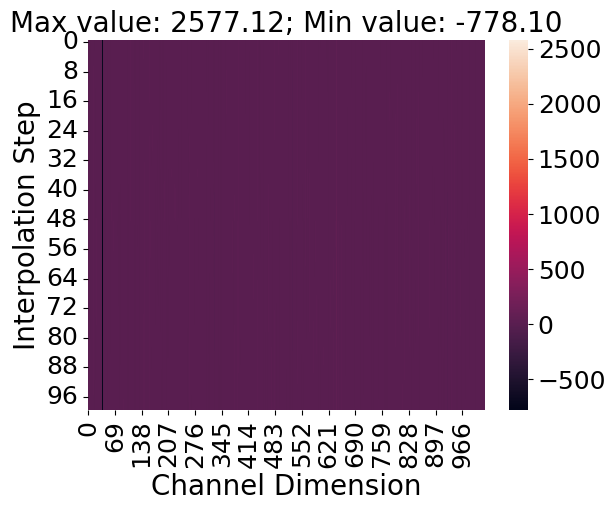

In [28]:
min_val = interpolated_features.min()
max_val = interpolated_features.max()
sns.heatmap(interpolated_features.detach().cpu().numpy())

plt.xlabel("Channel Dimension")
plt.ylabel("Interpolation Step")
plt.title(f"Max value: {max_val:.2f}; Min value: {min_val:.2f}")